之前做的GAN生成手写数字生成的数字是随机的，没法指定生成哪几个数字。

cGAN（conditional Generative Adversarial Nets），条件生成对抗网络，落通过添加限制条件，来控制GAN生成数据的类别。

参考资料：https://blog.csdn.net/Andrewseu/article/details/78260193

参考代码：https://github.com/arturml/mnist-cgan/blob/master/mnist-cgan.ipynb


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np

In [31]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    # https://blog.csdn.net/qq_31829611/article/details/90200694
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])
BATCH_SIZE = 32
mnist = torchvision.datasets.MNIST(root=r'D:\_workPlace\Book\AI\CV\HandwrittenDigitRecognition\MNIST_DATA',
                                   train=True,
                                   download=True,
                                   transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # https://blog.csdn.net/tommorrow12/article/details/80896331
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            # 28*28+10--> 1024
            nn.Linear(794, 1024),
            # LeakyReLU激活
            nn.LeakyReLU(0.2, inplace=True),
            # 30%随机置零
            nn.Dropout(0.3),
            # 1024 --> 512
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 512 --> 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 256 --> 1
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze() # https://blog.csdn.net/flysky_jay/article/details/81607289

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4 # learning rate
D = Discriminator()
G = Generator()
loss_func = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

In [29]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, loss_func):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = loss_func(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [10]:
def  discriminator_train_step(batch_size, discriminator, generator, d_optimizer, loss_func, real_images, labels):
    d_optimizer.zero_grad()
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = loss_func(real_validity, Variable(torch.ones(batch_size)).to(device))
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0,10, batch_size))).to(device)
    fake_images=generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = loss_func(fake_validity, Variable(torch.zeros(batch_size)))
    
    d_loss = real_loss+fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [32]:
# train
EPOCHS = 40
for epoch in range(EPOCHS):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        step = epoch * len(data_loader)+i+1
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # https://blog.csdn.net/qq_36653505/article/details/84728489
        G.train()
        d_loss = discriminator_train_step(len(real_images), D, G, d_optimizer, loss_func, real_images, labels)
        g_loss = generator_train_step(BATCH_SIZE, D, G, g_optimizer, loss_func)
        if step % 200 == 0:
            print("step:{0}, g_loss:{1}, d_loss:{2}".format(step, g_loss, d_loss))

print("Done!")

, g_loss:1.7283728122711182, d_loss:0.5969628095626831
step:15400, g_loss:2.3766238689422607, d_loss:0.5354121923446655
step:15600, g_loss:2.371612071990967, d_loss:0.469868540763855
step:15800, g_loss:1.2877240180969238, d_loss:0.39443671703338623
step:16000, g_loss:2.4129555225372314, d_loss:0.655976414680481
step:16200, g_loss:2.3533544540405273, d_loss:0.6644318103790283
step:16400, g_loss:2.071227550506592, d_loss:0.7078574895858765
step:16600, g_loss:1.6353187561035156, d_loss:0.6042506098747253
step:16800, g_loss:3.0466227531433105, d_loss:0.7085921764373779
Starting epoch 9...
step:17000, g_loss:1.7709468603134155, d_loss:0.9191223382949829
step:17200, g_loss:2.1654536724090576, d_loss:0.7638471722602844
step:17400, g_loss:1.1244697570800781, d_loss:1.030300259590149
step:17600, g_loss:1.9962244033813477, d_loss:0.6472523212432861
step:17800, g_loss:1.6557791233062744, d_loss:0.882902979850769
step:18000, g_loss:1.5269957780838013, d_loss:0.7492475509643555
step:18200, g_loss:2

In [33]:
# save model
torch.save(G.state_dict(), 'cGAN_Model\generator.pth')
torch.save(D.state_dict(), 'cGAN_Model\discriminator.pth')

In [34]:
# load model
def load_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    D = Discriminator() # 不能和类同名
    G = Generator()
    D.to(device=device)
    G.to(device=device)
    D.load_state_dict(torch.load('cGAN_Model/discriminator.pth', map_location=device))
    G.load_state_dict(torch.load('cGAN_Model/generator.pth', map_location=device))
    return G, D

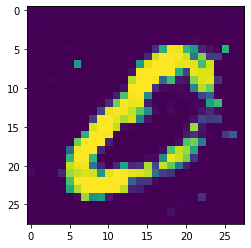

In [41]:
# test
import matplotlib.pyplot as plt

z = Variable(torch.randn(1, 100)).to(device)
label = torch.LongTensor([0]).to(device)
G, D = load_model()
img = G(z, label).data.to(device)
img = 0.5*img+0.5
c=transforms.ToPILImage()(img)
plt.imshow(c)
plt.show()